In [1]:
import os
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Bidirectional
from sklearn.metrics import roc_curve, auc

In [2]:
class ReadmissionReader:
    def __init__(self, root_dir, mode='train', seed=42):
        assert mode in ['train', 'test'], "Mode must be 'train' or 'test'"
        self.root_dir = root_dir
        self.mode_dir = os.path.join(root_dir, mode)
        self.seed = seed
        self.patient_files = self._get_patient_files()
        np.random.seed(seed)
        np.random.shuffle(self.patient_files)

    def _get_patient_files(self):
        patient_files = []
        for patient in os.listdir(self.mode_dir):
            patient_dir = os.path.join(self.mode_dir, patient)
            if os.path.isdir(patient_dir):
                patient_files.append(patient_dir)
        return patient_files

    def get_number_of_examples(self):
        return len(self.patient_files)

    def read_example(self, i):
        patient_dir = self.patient_files[i]
        patient_id = os.path.basename(patient_dir)
        episode_files = [f for f in os.listdir(patient_dir) if f.startswith('episode')]
        episode_timeseries_files = [f for f in episode_files if f.endswith('_timeseries.csv')]
        episode_timeseries_files.sort()

        # Check if there are any episode timeseries files
        if not episode_timeseries_files:
            return None

        # Load the first episode timeseries data
        episode1_timeseries_file = episode_timeseries_files[0]
        episode1_timeseries_path = os.path.join(patient_dir, episode1_timeseries_file)
        episode1_timeseries_data = pd.read_csv(episode1_timeseries_path)
        episode1_timeseries_data = episode1_timeseries_data.fillna('')
        # Get the header
        header = episode1_timeseries_data.columns.tolist()

        # Check if there are more than one episode timeseries files
        y_label = 1 if len(episode_timeseries_files) > 1 else 0

        # Get the total time
        total_time = float(episode1_timeseries_data.iloc[-1, 0])

        example = {
            'X': episode1_timeseries_data.values.astype(str),
            't': total_time,
            'y': y_label,
            'header': header,
            'name': f"{patient_id}_{episode1_timeseries_file}"
        }

        return example




In [3]:
dataset_dir = r"C:\Users\samit\OneDrive\Desktop\Datasets\data\decompensation"

root_dir = r'C:\Users\samit\OneDrive\Desktop\Datasets\data\root'

In [4]:
train_reader = ReadmissionReader(root_dir, mode='train')
test_reader = ReadmissionReader(root_dir, mode='test')
print("Number of training examples:", train_reader.get_number_of_examples())
print("Number of testing examples:", test_reader.get_number_of_examples())

Number of training examples: 28728
Number of testing examples: 5070


In [45]:
print(train_reader.read_example(1))

{'X': array([['-2.7847222222222223', '', '', ..., '', '', ''],
       ['1.715277777777778', '', '', ..., '', '', ''],
       ['2.1319444444444446', '', '', ..., '', '', ''],
       ...,
       ['192.76527777777773', '', '', ..., '', '', ''],
       ['214.61527777777775', '', '', ..., '', '', ''],
       ['241.71527777777777', '', '', ..., '', '', '']], dtype='<U19'), 't': 241.71527777777777, 'y': 0, 'header': ['Hours', 'Capillary refill rate', 'Diastolic blood pressure', 'Fraction inspired oxygen', 'Glascow coma scale eye opening', 'Glascow coma scale motor response', 'Glascow coma scale total', 'Glascow coma scale verbal response', 'Glucose', 'Heart Rate', 'Height', 'Mean blood pressure', 'Oxygen saturation', 'Respiratory rate', 'Systolic blood pressure', 'Temperature', 'Weight', 'pH'], 'name': '61113_episode1_timeseries.csv'}


In [ ]:
# Get the total number of examples
total_examples = train_reader.get_number_of_examples()

# Initialize a list to store the lengths of timeseries data for each patient
lengths = []
duration = []
# Loop through all the examples
for i in range(total_examples):
    example = train_reader.read_example(i)
    # Check if example is not None before accessing its keys
    if example is not None:
        # Append the length of the 'X' array to the lengths list
        lengths.append(len(example['X']))
        duration.append(example['t'])

In [ ]:
# Set Seaborn style
sns.set_style("whitegrid")

# Calculate the 90th percentile
percentile_90 = np.percentile(lengths, 90)

# Calculate the interquartile range (IQR)
Q1 = np.percentile(lengths, 25)
Q3 = np.percentile(lengths, 75)
IQR = Q3 - Q1

# Calculate the whis value such that it corresponds to the 90th percentile
whis_value = (percentile_90 - Q1) / IQR

# Create the vertical box plot with a bright gradient color without showing outliers above the 90th percentile
plt.figure(figsize=(7, 5))
sns.boxplot(y=lengths, palette="viridis", width=0.3, whis=whis_value, showfliers=False)

# Plot a horizontal line for the average and label it
average_length = np.mean(lengths)
plt.axhline(y=average_length, color='red', linestyle='--', label=f'Average: {average_length:.2f}')
plt.legend(loc='upper right', fontsize=12)

plt.title('Box Plot of Length of Timeseries Data', fontsize=16)
plt.ylabel('Length of Timeseries Data', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(left=True)

plt.show()

In [6]:
def discretize(data, timestep=0.8, impute_strategy='previous', start_time='zero'):
    """
    Discretizes the time series data into fixed timesteps and fills missing values.
    """
    # Sort data by time
    data = sorted(data, key=lambda x: float(x[0]))

    # Create an array for discretized data
    discretized_data = []

    # Fill missing values
    prev_values = None
    for i in range(len(data)):
        if i == 0 and start_time == 'zero':
            row = ['0.0'] + list(data[i][1:])  # Change 0 to '0.0' to match the data type
        else:
            row = list(data[i])

        if impute_strategy == 'previous':
            if prev_values is not None:
                row = [(row[j] if row[j] != '' else prev_values[j]) for j in range(len(row))]
            prev_values = row

        discretized_data.append(row)

    # Transform into fixed timestep format
    time_intervals = np.arange(0, max([float(row[0]) for row in discretized_data]) + timestep, timestep)
    fixed_timestep_data = []
    for t in time_intervals:
        fixed_timestep_data.append([str(t)] + [row[1:] for row in discretized_data if float(row[0]) <= t][-1])

    # Handle missing values (replace empty strings and non-numeric values with '0.0')
    #fixed_timestep_data = [[('0.0' if (cell == '' or not cell.replace('.', '', 1).isdigit()) else cell) for cell in row] for row in fixed_timestep_data]

    # Convert to numerical format and handle missing values
    
    for i, channel in enumerate(CHANNELS.keys()):
        if CHANNELS[channel] == 'categorical':
            category_mapping = global_category_mapping[channel]
            fixed_timestep_data_array = np.array(fixed_timestep_data)
            for category, mapped_value in category_mapping.items():
                fixed_timestep_data_array[fixed_timestep_data_array[:, i+1] == category, i+1] = mapped_value
            fixed_timestep_data = fixed_timestep_data_array.tolist()
     
    fixed_timestep_data = [[('0.0' if (cell == '' or not cell.replace('.', '', 1).isdigit()) else cell) for cell in row] for row in fixed_timestep_data]

    df = pd.DataFrame(fixed_timestep_data, columns=['Time'] + ['Var' + str(i) for i in range(1, len(fixed_timestep_data[0]))])
    df = df.replace('', np.nan)
    df = df.fillna(method='ffill')
    df = df.fillna(0)  # Fill any remaining missing values with 0

    # Convert back to numpy array
    numerical_data = df.values.astype(np.float32)
#     numerical_data = np.array(fixed_timestep_data, dtype=np.float32)
#     numerical_data[np.isnan(numerical_data)] = 0


    return numerical_data








In [7]:
def normalize(data):
    """
    Normalizes the data by scaling the continuous features to have a mean of 0 and a standard deviation of 1.
    """
    channels = CHANNELS
    # Separate time and features
    time = data[:, 0]
    features = data[:, 1:]

    # Identify the indices of the continuous and categorical features
    continuous_indices = [i for i, channel in enumerate(channels.keys()) if channels[channel] == 'numerical']
    categorical_indices = [i for i, channel in enumerate(channels.keys()) if channels[channel] == 'categorical']

    # Separate continuous and categorical features
    continuous_features = features[:, continuous_indices]
    categorical_features = features[:, categorical_indices]

    # Standardize the continuous features
    scaler = StandardScaler()
    standardized_continuous_features = scaler.fit_transform(continuous_features)

    # Create an empty array to hold the standardized features
    standardized_features = np.empty(features.shape, dtype=features.dtype)

    # Put the standardized continuous features back into their original positions
    for i, index in enumerate(continuous_indices):
        standardized_features[:, index] = standardized_continuous_features[:, i]

    # Put the transformed categorical features back into their original positions
    for i, index in enumerate(categorical_indices):
        standardized_features[:, index] = categorical_features[:, i]

    # Concatenate time and standardized features
    normalized_data = np.column_stack((time, standardized_features))

    return normalized_data






In [64]:
def pad_zeros(arr, max_length=142):
    """
    `arr` is an array of `np.array`s

    The function appends zeros to every `np.array` in `arr`
    to equalize their first axis lengths.
    """
    dtype = arr[0].dtype
    if max_length is None:
        max_len = max([x.shape[0] for x in arr])
    else:
        max_len = max_length
    ret = []
    for x in arr:
        if x.shape[0] > max_len:
            ret.append(x[:max_len, :])  # Truncate longer sequences
        else:
            ret.append(np.concatenate([x, np.zeros((max_len - x.shape[0],) + x.shape[1:], dtype=dtype)], axis=0))
    return np.array(ret)



# average_time_length = 142  # Rounded up to the nearest integer
# padded_train_data = pad_zeros(train_data_timeseries, min_length=average_time_length)


In [9]:
CHANNELS = {
    'Capillary refill rate': 'categorical',
    'Diastolic blood pressure': 'numerical',
    'Fraction inspired oxygen': 'numerical',
    'Glascow coma scale eye opening': 'categorical',
    'Glascow coma scale motor response': 'categorical',
    'Glascow coma scale total': 'numerical',
    'Glascow coma scale verbal response': 'categorical',
    'Glucose': 'numerical',
    'Heart Rate': 'numerical',
    'Height': 'numerical',
    'Mean blood pressure': 'numerical',
    'Oxygen saturation': 'numerical',
    'Respiratory rate': 'numerical',
    'Systolic blood pressure': 'numerical',
    'Temperature': 'numerical',
    'Weight': 'numerical',
    'pH':'numerical'
}
# CHANNELS = {
#     'Diastolic blood pressure': 'numerical',
#     'Fraction inspired oxygen': 'numerical',
#     'Glascow coma scale eye opening': 'categorical',
#     'Glascow coma scale motor response': 'categorical',
#     'Glascow coma scale total': 'numerical',
#     'Glascow coma scale verbal response': 'categorical',
#     'Glucose': 'numerical',
#     'Heart Rate': 'numerical',
#     'Mean blood pressure': 'numerical',
#     'Oxygen saturation': 'numerical',
#     'Respiratory rate': 'numerical',
#     'Systolic blood pressure': 'numerical',
#     'Temperature': 'numerical',
#     'Weight': 'numerical'
# }

In [10]:
# from collections import defaultdict

# # Initialize a dictionary to store the unique categories for each categorical variable
# # Initialize a dictionary to store the unique categories for each categorical variable
# unique_categories = defaultdict(set)

# # Load the time series data for all patients
# for i in range(train_reader.get_number_of_examples()-1):
#     data = train_reader.read_example(i)
#     if data is None:
#         continue
#     for channel, dtype in CHANNELS.items():
#         if dtype == 'categorical':
#             index = data['header'].index(channel)
#             categories = set(data['X'][:, index])
#             unique_categories[channel].update(categories)


# # Create a global mapping of categories to indices for each categorical variable
global_category_mapping = {}
for channel, categories in unique_categories.items():
    global_category_mapping[channel] = {category: i for i, category in enumerate(categories)}

In [11]:
global_category_mapping = {'Capillary refill rate': {'': 0,
  '0.0': 1,
  '1': 2 },
  'Glascow coma scale eye opening': {'': 0,
  'To Pain': 1,
  'None': 2,
  'Spontaneously': 3,
  'To Speech': 4,
  '4 Spontaneously': 5,
  '1 No Response': 6,
  '2 To pain': 7,
  '3 To speech': 8},
 'Glascow coma scale motor response': {'': 0,
  'Localizes Pain': 1,
  '3 Abnorm flexion': 2,
  'Abnormal extension': 3,
  '5 Localizes Pain': 4,
  '6 Obeys Commands': 5,
  'Flex-withdraws': 6,
  '2 Abnorm extensn': 7,
  'Obeys Commands': 8,
  'Abnormal Flexion': 9,
  'No response': 10,
  '4 Flex-withdraws': 11,
  '1 No Response': 12},
 'Glascow coma scale verbal response': {'': 0,
  'Inappropriate Words': 1,
  'Incomprehensible sounds': 2,
  'Oriented': 3,
  '2 Incomp sounds': 4,
  '4 Confused': 5,
  'No Response-ETT': 6,
  '3 Inapprop words': 7,
  'Confused': 8,
  'No Response': 9,
  '1.0 ET/Trach': 10,
  '5 Oriented': 11,
  '1 No Response': 12}}

In [12]:
# Define the mappings for the categorical columns
admission_mapping = {'UNKNOWN': 0, 'EMERGENCY': 1, 'ELECTIVE': 2, 'URGENT': 3}
dbsource_mapping = {'carevue': 1, 'metavision': 2, 'both': 3}
icu_unit_mapping = {'MICU': 1, 'CCU': 2, 'TSICU': 3, 'SICU': 4, 'CSRU': 5}

def get_static_features(reader, index, root):
    # Read the example from the reader
    example = reader.read_example(index)
    
    # Extract the patient ID and episode number from the file name
    file_name = example['name']
    patient_id, episode_num = file_name.split('_')[0], file_name.split('_')[1].replace('episode', '')
    
    # Define the root directory and train folder
    if root == 'train':
        train_dir = os.path.join(root_dir, 'train')
    elif root == 'test':
        train_dir = os.path.join(root_dir, 'test')
    
    # Load the combined data
    combined_data = pd.read_csv('combined_data')
    
    # Access the patient folder
    patient_path = os.path.join(train_dir, patient_id)
    
    # Load the stays data
    stays_data = pd.read_csv(os.path.join(patient_path, 'stays.csv'))
    
    # Access the episode folder
    #episode_path = os.path.join(patient_path, f'episode{episode_num}')
    
    # Load the episode data
    episode_data = pd.read_csv(os.path.join(patient_path, f'episode{episode_num}.csv'))
    
    # Extract the relevant features
    age = episode_data['Age'].values[0]
    height = episode_data['Height'].values[0]
    weight = episode_data['Weight'].values[0]
    ethnicity = episode_data['Ethnicity'].values[0]
    gender = episode_data['Gender'].values[0]
    dbsource = stays_data['DBSOURCE'].values[0]
    last_careunit = stays_data['LAST_CAREUNIT'].values[0]
    
    # Get the admission type from the combined data
    # Get the admission type from the combined data
    icustay_id = stays_data['ICUSTAY_ID'].values[0]
    matching_rows = combined_data[combined_data['ICUSTAY_ID'] == icustay_id]

    if not matching_rows.empty:
        admission_type = matching_rows['ADMISSION_TYPE'].values[0]
    else:
        # Handle the case where there are no matching rows
        print(f"No matching rows found for ICUSTAY_ID {icustay_id}")
        admission_type = "UNKNOWN"

    
    # Create the static data vector
    static_data_vector = [age, height, weight, gender,ethnicity, dbsource, last_careunit, admission_type]


    return static_data_vector

In [47]:
total_time_length = 0
num_patients = train_reader.get_number_of_examples()

for i in range(num_patients-1):
    data = train_reader.read_example(i)
    if data is None:
        continue
    elif data['y'] ==1:
        total_time_length += data['X'].shape[0]

average_time_length = total_time_length / num_patients
print(f"Average time length for all patients: {average_time_length}")


Average time length for all patients: 23.256927039821775


In [67]:
# Process training data
train_data_timeseries = []
train_data_static = []
train_labels = []
#drop_features = ['Height', 'Capillary refill rate']

for i in range(train_reader.get_number_of_examples()-1):
    example = train_reader.read_example(i)
    if example is None:
        print(f"Example {i} is None")
        continue
    #     drop_indices = [example['header'].index(feature) for feature in drop_features]
    #     data = np.array(example['X'], dtype='<U20')
    #     data = np.delete(data, drop_indices, axis=1)
    #     example['X'] = data
    #     example['header'] = [header for j, header in enumerate(example['header']) if j not in drop_indices]
    discretized_data = discretize(example['X'])
    normalized_data = normalize(discretized_data)

    # Get the static data vector
    static_data_vector = get_static_features(train_reader, i,'train')
    for j in range(len(static_data_vector)):
        if isinstance(static_data_vector[j], (int, float)):
            static_data_vector[j] = float(static_data_vector[j])
        # Convert the static data vector into a numpy array and repeat it to match the shape of the time series data
    static_data_array = np.array(static_data_vector,dtype=object)
    #static_data_array = np.repeat(np.array(static_data_vector)[np.newaxis, :], normalized_data.shape[0], axis=0)

    # Concatenate the static data array with the time series data
    #concatenated_data = np.concatenate((normalized_data, static_data_array), axis=1)

    train_data_timeseries.append(normalized_data)
    train_data_static.append(static_data_array)
    train_labels.append(example['y'])
padded_train_data = pad_zeros(train_data_timeseries,142)
static_data_df = pd.DataFrame(train_data_static, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
static_data_df['AdmissionType'] = static_data_df['AdmissionType'].map(admission_mapping)
static_data_df['DBSource'] = static_data_df['DBSource'].map(dbsource_mapping)
static_data_df['LastCareUnit'] = static_data_df['LastCareUnit'].map(icu_unit_mapping)
numerical_features = ['Age', 'Height', 'Weight']
# Standardize the numerical features
scaler = StandardScaler()
scaler.fit(static_data_df[numerical_features])
static_data_df[numerical_features] = scaler.transform(static_data_df[numerical_features])
train_data_static = static_data_df.to_numpy()

#padded_train_data = np.concatenate(padded_train_data, axis=0)
#train_labels = to_categorical(train_labels)

test_data_timeseries = []
test_data_static = []
test_labels = []
for i in range(test_reader.get_number_of_examples()-1):
    example = test_reader.read_example(i)
    if example is None:
        print(f"Example {i} is None")
        continue
#     drop_indices = [example['header'].index(feature) for feature in drop_features]
#     data = np.array(example['X'], dtype='<U20')
#     data = np.delete(data, drop_indices, axis=1)
#     example['X'] = data
#     example['header'] = [header for j, header in enumerate(example['header']) if j not in drop_indices]
    discretized_data = discretize(example['X'])
    normalized_data = normalize(discretized_data)

    # Get the static data vector
    static_data_vector_test = get_static_features(test_reader, i,'test')
    for j in range(len(static_data_vector_test)):
        if isinstance(static_data_vector_test[j], (int, float)):
            static_data_vector_test[j] = float(static_data_vector_test[j])

    # Convert the static data vector into a numpy array and repeat it to match the shape of the time series data
    static_data_array_test = np.array(static_data_vector_test, dtype=object)

    test_data_timeseries.append(normalized_data)
    test_data_static.append(static_data_array_test)
    test_labels.append(example['y'])
padded_test_data = pad_zeros(test_data_timeseries,142)
static_data_test_df = pd.DataFrame(test_data_static, columns=['Age', 'Height', 'Weight', 'Gender', 'Ethnicity', 'DBSource', 'LastCareUnit', 'AdmissionType'])
static_data_test_df['AdmissionType'] = static_data_test_df['AdmissionType'].map(admission_mapping)
static_data_test_df['DBSource'] = static_data_test_df['DBSource'].map(dbsource_mapping)
static_data_test_df['LastCareUnit'] = static_data_test_df['LastCareUnit'].map(icu_unit_mapping)
static_data_test_df[numerical_features] = scaler.transform(static_data_test_df[numerical_features])
test_data_static = static_data_test_df.to_numpy()


Example 931 is None
Example 1524 is None
Example 1724 is None
Example 1730 is None
Example 4787 is None
Example 4832 is None
Example 5879 is None
Example 6079 is None
Example 6211 is None
No matching rows found for ICUSTAY_ID 246075
Example 6862 is None
Example 8091 is None
Example 8556 is None
Example 10275 is None
No matching rows found for ICUSTAY_ID 292281
Example 12149 is None
Example 12373 is None
Example 13144 is None
Example 13719 is None
Example 14038 is None
Example 16382 is None
Example 16458 is None
Example 16906 is None
Example 17171 is None
Example 17265 is None
Example 19262 is None
Example 19299 is None
Example 19801 is None
Example 21693 is None
Example 23117 is None
Example 23240 is None
No matching rows found for ICUSTAY_ID 265303
No matching rows found for ICUSTAY_ID 283217
Example 25245 is None
Example 25331 is None
Example 26077 is None
Example 27002 is None
Example 28358 is None
Example 28494 is None
Example 656 is None
Example 1536 is None
Example 3504 is None


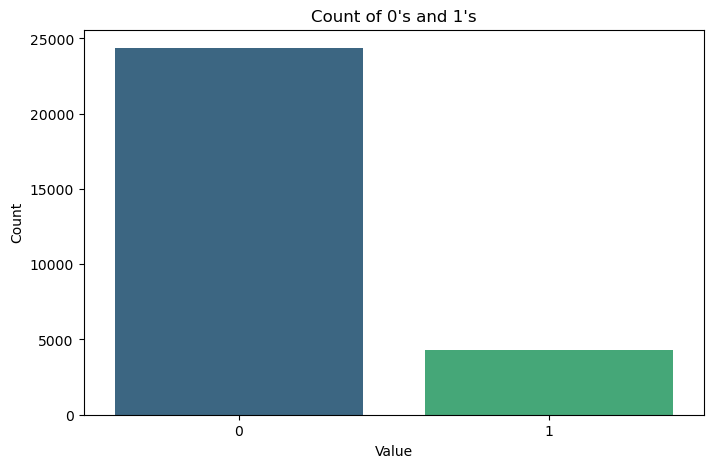

In [189]:
# Count the occurrences of each value
(unique_values, counts) = np.unique(train_labels, return_counts=True)

# Create a dictionary from unique values and counts
value_counts = dict(zip(unique_values, counts))

# Create a bar plot of the counts
plt.figure(figsize=(8, 5))
sns.barplot(x=list(value_counts.keys()), y=list(value_counts.values()), palette='viridis')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Count of 0\'s and 1\'s')
plt.show()



In [190]:
value_counts

{0: 24361, 1: 4331}

In [71]:
padded_train_data.shape

(28692, 142, 18)

In [78]:
# Calculate the number of nan values in each column of padded_train_data
nan_counts_padded = np.isnan(padded_train_data).sum(axis=0)

# Calculate the total number of values in each column of padded_train_data
total_counts_padded = padded_train_data.shape[0]

# Calculate the percentage of nan values in each column of padded_train_data
nan_percentage_padded = (nan_counts_padded / total_counts_padded) * 100

# Calculate the number of nan values in each column of train_static_data
nan_counts_static = np.isnan(train_data_static).sum(axis=0)

# Calculate the total number of values in each column of train_static_data
total_counts_static = train_data_static.shape[0]

# Calculate the percentage of nan values in each column of train_static_data
nan_percentage_static = (nan_counts_static / total_counts_static) * 100

print("Percentage of nan values in each column of padded_train_data:", nan_percentage_padded)
print("Percentage of nan values in each column of train_static_data:", nan_percentage_static)



Percentage of nan values in each column of padded_train_data: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Percentage of nan values in each column of train_static_data: [0. 0. 0. 0. 0. 0. 0.]


In [74]:
for i in range(padded_train_data.shape[0]):
    for j in range(padded_train_data.shape[1]):
        dataset = padded_train_data[i, j, :]
        nan_indices = np.isnan(dataset)
        mean_value = np.nanmean(dataset)
        dataset[nan_indices] = mean_value
        padded_train_data[i, j, :] = dataset

In [75]:
for i in range(padded_test_data.shape[0]):
    for j in range(padded_test_data.shape[1]):
        dataset = padded_test_data[i, j, :]
        nan_indices = np.isnan(dataset)
        mean_value = np.nanmean(dataset)
        dataset[nan_indices] = mean_value
        padded_test_data[i, j, :] = dataset

In [76]:
# Assuming val_data_static is a numpy array
column_index_to_drop = 1  # Index of the column with 74.45% nan values
train_data_static = np.delete(train_data_static, column_index_to_drop, axis=1)
test_data_static = np.delete(test_data_static,column_index_to_drop, axis=1 ) 

In [77]:
# Assuming train_static_data and val_static_data are your static data arrays
# Assuming the weight column is the second column (index 1)

# Calculate the mean of the non-missing values in the weight column of the training data
mean_weight_train = np.nanmean(train_data_static[:, 1])

# Impute the missing values in the weight column of the training data with the mean
train_data_static[:, 1] = np.where(np.isnan(train_data_static[:, 1]), mean_weight_train, train_data_static[:, 1])

# Impute the missing values in the weight column of the validation data with the mean from the training data
test_data_static[:, 1] = np.where(np.isnan(test_data_static[:, 1]), mean_weight_train, test_data_static[:, 1])


In [102]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Define the LSTM layers for the time series data
lstm_layer = LSTM(64, return_sequences=True)(time_series_input)
lstm_layer = LSTM(32)(lstm_layer)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([lstm_layer, static_input])

# Define the dense layers
# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add a Dropout layer with a rate of 0.5
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add another Dropout layer with a rate of 0.5
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Create the model
model = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 18)]   0           []                               
                                                                                                  
 lstm_6 (LSTM)                  (None, None, 64)     21248       ['input_7[0][0]']                
                                                                                                  
 lstm_7 (LSTM)                  (None, 32)           12416       ['lstm_6[0][0]']                 
                                                                                                  
 input_8 (InputLayer)           [(None, 7)]          0           []                               
                                                                                            

In [87]:
# Compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [93]:
count_ones = np.sum(train_labels == 0)

In [94]:
count_ones

24361

In [103]:
# Convert the labels to NumPy arrays
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

# Fit the model
history = model.fit(
    [padded_train_data, train_data_static], train_labels,
    validation_split = 0.15,
    class_weight = class_weight_dict,
    epochs=20,
    batch_size=32
)

Epoch 1/20
763/763 [==============================] - 42s 52ms/step - loss: 0.6840 - accuracy: 0.5400 - val_loss: 0.6237 - val_accuracy: 0.6633
Epoch 2/20
763/763 [==============================] - 38s 50ms/step - loss: 0.6721 - accuracy: 0.5402 - val_loss: 0.6545 - val_accuracy: 0.5913
Epoch 3/20
763/763 [==============================] - 39s 51ms/step - loss: 0.6719 - accuracy: 0.5549 - val_loss: 0.6329 - val_accuracy: 0.5922
Epoch 4/20
763/763 [==============================] - 38s 50ms/step - loss: 0.6687 - accuracy: 0.5509 - val_loss: 0.6288 - val_accuracy: 0.6522
Epoch 5/20
763/763 [==============================] - 39s 51ms/step - loss: 0.6678 - accuracy: 0.5697 - val_loss: 0.6569 - val_accuracy: 0.5778
Epoch 6/20
763/763 [==============================] - 38s 50ms/step - loss: 0.6693 - accuracy: 0.5481 - val_loss: 0.7021 - val_accuracy: 0.5374
Epoch 7/20
763/763 [==============================] - 38s 50ms/step - loss: 0.6665 - accuracy: 0.5824 - val_loss: 0.6436 - val_accuracy:

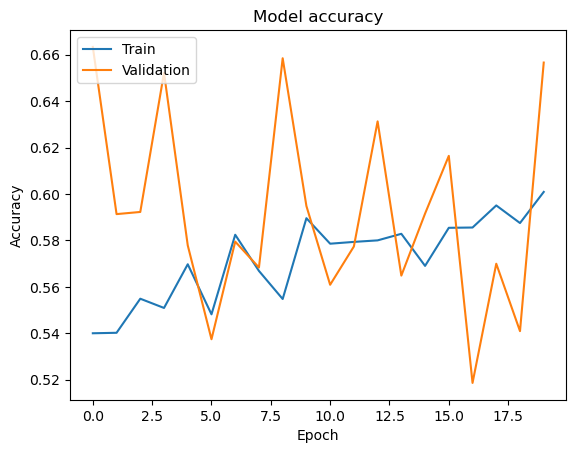

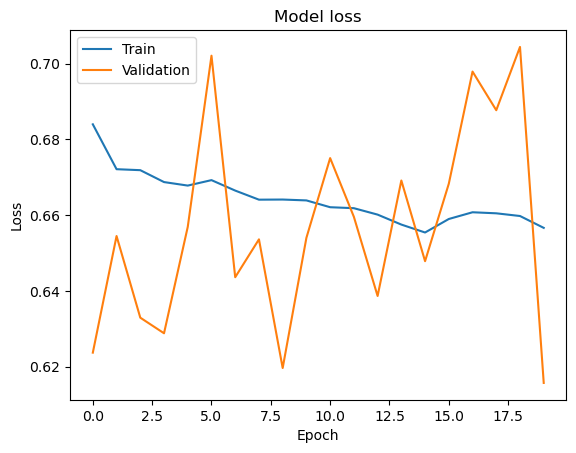

In [104]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [105]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict the probabilities of the test data
y_pred_probs = model.predict([padded_test_data, test_data_static])

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


159/159 [==============================] - 3s 18ms/step
AUC-ROC Score: 0.67029434483212
Accuracy: 0.6506119226213976
Precision: 0.23626666666666668
Recall: 0.5672215108834827
F1 Score: 0.3335843373493976


In [106]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout, Bidirectional

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Define the Bidirectional LSTM layers for the time series data
bi_lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(time_series_input)
bi_lstm_layer = Bidirectional(LSTM(32))(bi_lstm_layer)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([bi_lstm_layer, static_input])

# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add a Dropout layer with a rate of 0.5
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add another Dropout layer with a rate of 0.5
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Create the model
model1 = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model1.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, 18)]   0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, None, 128)   42496       ['input_9[0][0]']                
 )                                                                                                
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 64)          41216       ['bidirectional_4[0][0]']        
 )                                                                                                
                                                                                            

In [107]:
history1 = model1.fit(
    [padded_train_data, train_data_static], train_labels,
    validation_split = 0.15,
    class_weight = class_weight_dict,
    epochs=20,
    batch_size=32
)

Epoch 1/20
763/763 [==============================] - 56s 68ms/step - loss: 0.6836 - accuracy: 0.5337 - val_loss: 0.7314 - val_accuracy: 0.4470
Epoch 2/20
763/763 [==============================] - 52s 68ms/step - loss: 0.6718 - accuracy: 0.5583 - val_loss: 0.7133 - val_accuracy: 0.4707
Epoch 3/20
763/763 [==============================] - 51s 67ms/step - loss: 0.6655 - accuracy: 0.5593 - val_loss: 0.5419 - val_accuracy: 0.7414
Epoch 4/20
763/763 [==============================] - 51s 67ms/step - loss: 0.6623 - accuracy: 0.5713 - val_loss: 0.6337 - val_accuracy: 0.6266
Epoch 5/20
763/763 [==============================] - 51s 67ms/step - loss: 0.6573 - accuracy: 0.5671 - val_loss: 0.6424 - val_accuracy: 0.5883
Epoch 6/20
763/763 [==============================] - 51s 67ms/step - loss: 0.6536 - accuracy: 0.5703 - val_loss: 0.6711 - val_accuracy: 0.5407
Epoch 7/20
763/763 [==============================] - 51s 67ms/step - loss: 0.6483 - accuracy: 0.5718 - val_loss: 0.6470 - val_accuracy:

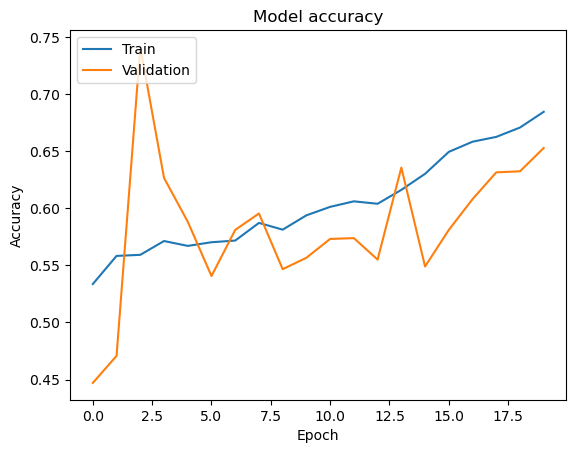

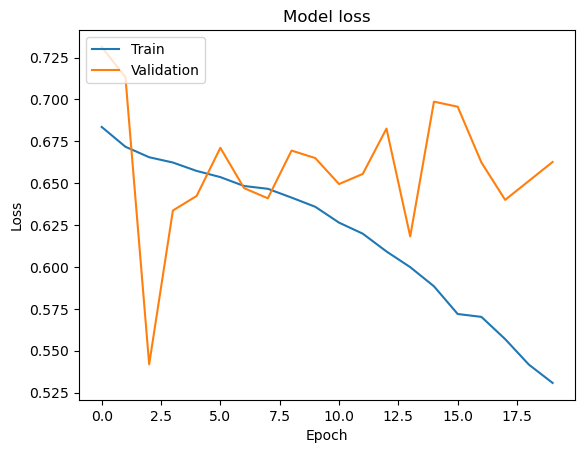

In [108]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [109]:
# Predict the probabilities of the test data
y_pred_probs = model1.predict([padded_test_data, test_data_static])

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

159/159 [==============================] - 4s 24ms/step
AUC-ROC Score: 0.6136875352037973
Accuracy: 0.6466640347414133
Precision: 0.21384004537719795
Recall: 0.4827144686299616
F1 Score: 0.29638364779874216


In [115]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
# Define model parameters
input_shape = (padded_train_data.shape[1], padded_train_data.shape[2])
output_size = 1  # Binary classification (0 or 1)

# Build the LSTM model
model4 = Sequential()
model4.add(LSTM(64, input_shape=input_shape, return_sequences=True))
model4.add(Dropout(0.3))  # Add dropout layer with 20% dropout rate
model4.add(LSTM(32))
model4.add(Dropout(0.3))  # Add dropout layer with 20% dropout rate
model4.add(Dense(output_size, activation='sigmoid'))

# Compile the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, 142, 64)           21248     
                                                                 
 dropout_14 (Dropout)        (None, 142, 64)           0         
                                                                 
 lstm_83 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 33,697
Trainable params: 33,697
Non-trainable params: 0
_________________________________________________________________


In [119]:
history3 = model4.fit(padded_train_data, train_labels, 
                    epochs=20, 
                    batch_size=32,
                    class_weight = class_weight_dict,
                    validation_split = 0.15)

Epoch 1/20
763/763 [==============================] - 71s 90ms/step - loss: 0.6867 - accuracy: 0.5520 - val_loss: 0.6685 - val_accuracy: 0.5251
Epoch 2/20
763/763 [==============================] - 89s 117ms/step - loss: 0.6852 - accuracy: 0.5147 - val_loss: 0.6845 - val_accuracy: 0.4377
Epoch 3/20
763/763 [==============================] - 88s 116ms/step - loss: 0.6844 - accuracy: 0.4959 - val_loss: 0.6436 - val_accuracy: 0.5562
Epoch 4/20
763/763 [==============================] - 89s 117ms/step - loss: 0.6840 - accuracy: 0.5235 - val_loss: 0.6926 - val_accuracy: 0.4719
Epoch 5/20
763/763 [==============================] - 89s 117ms/step - loss: 0.6834 - accuracy: 0.5299 - val_loss: 0.6713 - val_accuracy: 0.5497
Epoch 6/20
763/763 [==============================] - 89s 117ms/step - loss: 0.6830 - accuracy: 0.5253 - val_loss: 0.6776 - val_accuracy: 0.4837
Epoch 7/20
763/763 [==============================] - 88s 116ms/step - loss: 0.6817 - accuracy: 0.5307 - val_loss: 0.6957 - val_acc

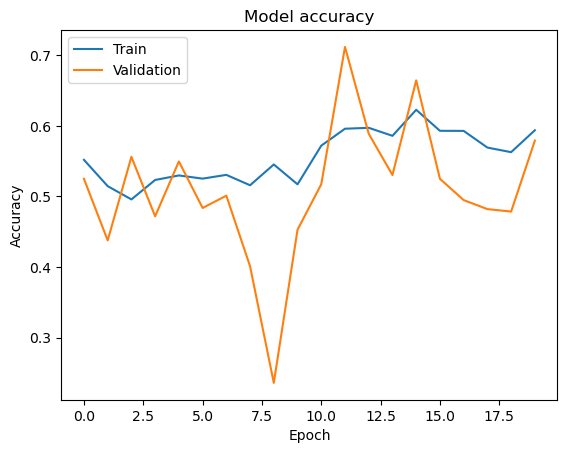

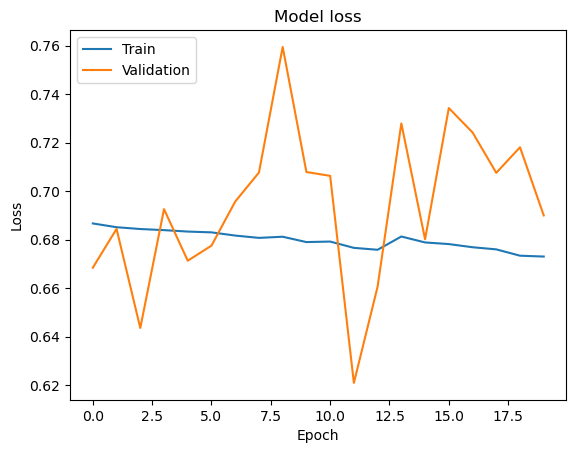

In [120]:
import matplotlib.pyplot as plt

plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [121]:
# Predict the probabilities of the test data
y_pred_probs = model4.predict(padded_test_data)

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

159/159 [==============================] - 6s 35ms/step
AUC-ROC Score: 0.6056947604797128
Accuracy: 0.5718515594157126
Precision: 0.19534679543459174
Recall: 0.5697823303457106
F1 Score: 0.2909447531873161


In [128]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Dropout

# Define the input shape for the time series data
time_series_input = Input(shape=(None, padded_train_data.shape[2]))

# Define the input shape for the static features
static_input = Input(shape=(train_data_static.shape[1],))

# Create separate LSTM layers for each channel in the time series data
lstm_outputs = []
for i in range(padded_train_data.shape[2]):
    channel_input = time_series_input[:,:,i:i+1]  # Select the i-th channel from the input data
    lstm_layer = LSTM(64, return_sequences=True)(channel_input)
    lstm_layer = LSTM(32)(lstm_layer)
    lstm_outputs.append(lstm_layer)

# Concatenate the outputs of the LSTM layers
concat_lstm = Concatenate()(lstm_outputs)

# Concatenate the LSTM output with the static features
concat_layer = Concatenate()([concat_lstm, static_input])

# Define the dense layers
dense_layer = Dense(64, activation='relu')(concat_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add a Dropout layer with a rate of 0.5
dense_layer = Dense(32, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)  # Add another Dropout layer with a rate of 0.5
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Create the model
model3 = Model(inputs=[time_series_input, static_input], outputs=output_layer)

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model3.summary()


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, None, 18)]   0           []                               
                                                                                                  
 tf.__operators__.getitem_90 (S  (None, None, 1)     0           ['input_21[0][0]']               
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_91 (S  (None, None, 1)     0           ['input_21[0][0]']               
 licingOpLambda)                                                                                  
                                                                                           

In [129]:
history2 = model3.fit(
    [padded_train_data, train_data_static], train_labels,
    validation_split = 0.15,
    class_weight = class_weight_dict,
    epochs=10,
    batch_size=32
)

Epoch 1/10
763/763 [==============================] - 2209s 3s/step - loss: 0.6825 - accuracy: 0.5515 - val_loss: 0.6974 - val_accuracy: 0.4877
Epoch 2/10
763/763 [==============================] - 2114s 3s/step - loss: 0.6754 - accuracy: 0.5469 - val_loss: 0.6765 - val_accuracy: 0.5558
Epoch 3/10
763/763 [==============================] - 2132s 3s/step - loss: 0.6730 - accuracy: 0.5501 - val_loss: 0.7225 - val_accuracy: 0.4693
Epoch 4/10
763/763 [==============================] - 2160s 3s/step - loss: 0.6712 - accuracy: 0.5393 - val_loss: 0.6744 - val_accuracy: 0.5165
Epoch 5/10
763/763 [==============================] - 2234s 3s/step - loss: 0.6671 - accuracy: 0.5411 - val_loss: 0.7097 - val_accuracy: 0.5044
Epoch 6/10
763/763 [==============================] - 2207s 3s/step - loss: 0.6663 - accuracy: 0.5430 - val_loss: 0.6559 - val_accuracy: 0.6501
Epoch 7/10
763/763 [==============================] - 2272s 3s/step - loss: 0.6661 - accuracy: 0.5524 - val_loss: 0.6929 - val_accuracy:

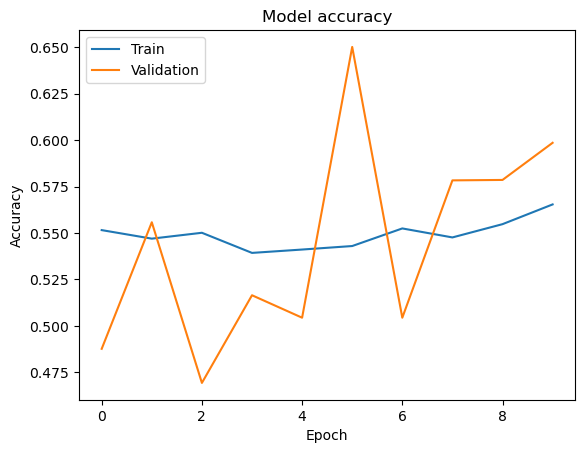

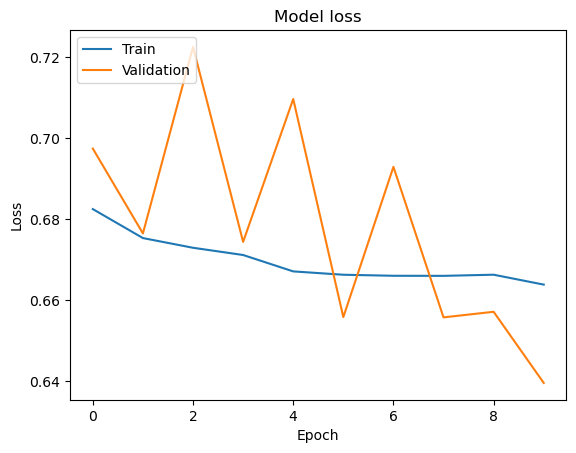

In [130]:
# Plot the training history
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [131]:
# Predict the probabilities of the test data
y_pred_probs = model3.predict([padded_test_data, test_data_static])

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

159/159 [==============================] - 176s 1s/step
AUC-ROC Score: 0.6510681784565461
Accuracy: 0.5955388866956178
Precision: 0.21645796064400716
Recall: 0.6197183098591549
F1 Score: 0.3208485250248591


159/159 [==============================] - 12s 77ms/step


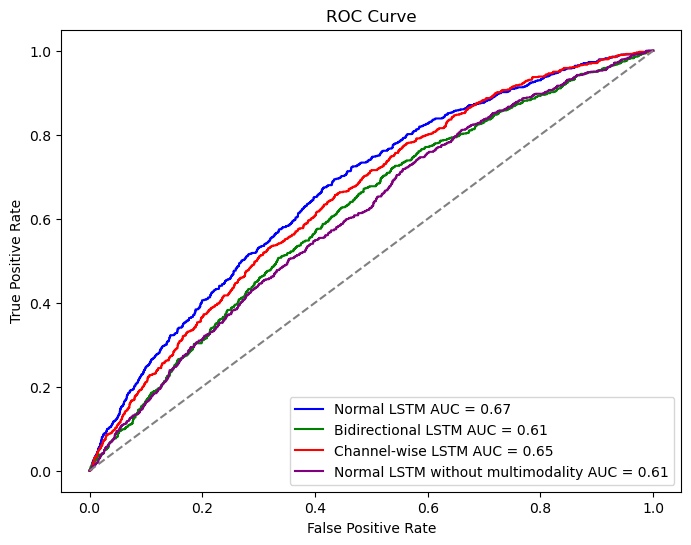

In [132]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define a function to plot the AUC-ROC curve for each model
def plot_roc_curve(model, X_val, y_val, label, color):
    y_pred = model.predict(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label='{} AUC = {:.2f}'.format(label, auc_value))

# Plot the AUC-ROC curves for each model in a single plot
plt.figure(figsize=(8, 6))
plot_roc_curve(model, [padded_test_data, test_data_static], test_labels, 'Normal LSTM', 'blue')
plot_roc_curve(model1, [padded_test_data, test_data_static], test_labels, 'Bidirectional LSTM', 'green')
plot_roc_curve(model3, [padded_test_data, test_data_static], test_labels, 'Channel-wise LSTM', 'red')
plot_roc_curve(model4, padded_test_data, test_labels, 'Normal LSTM without multimodality', 'purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



159/159 [==============================] - 21s 132ms/step
AUC-ROC Score: 0.6056947604797128
Accuracy: 0.5718515594157126
Precision: 0.19534679543459174
Recall: 0.5697823303457106
F1 Score: 0.2909447531873161


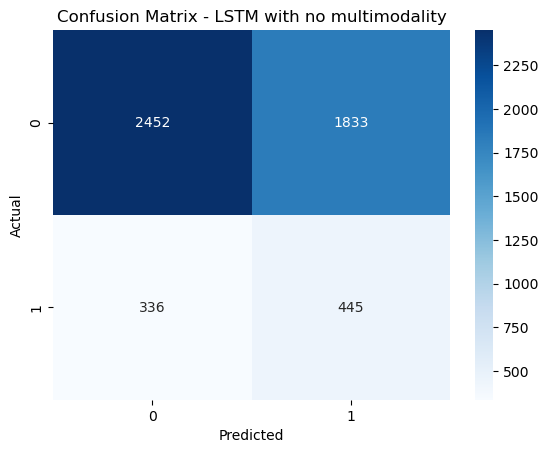

In [163]:
# Predict the probabilities of the test data
y_pred_probs = model4.predict(padded_test_data)

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - LSTM with no multimodality')
plt.show()


159/159 [==============================] - 244s 2s/step
AUC-ROC Score: 0.6510681784565461
Accuracy: 0.5955388866956178
Precision: 0.21645796064400716
Recall: 0.6197183098591549
F1 Score: 0.3208485250248591


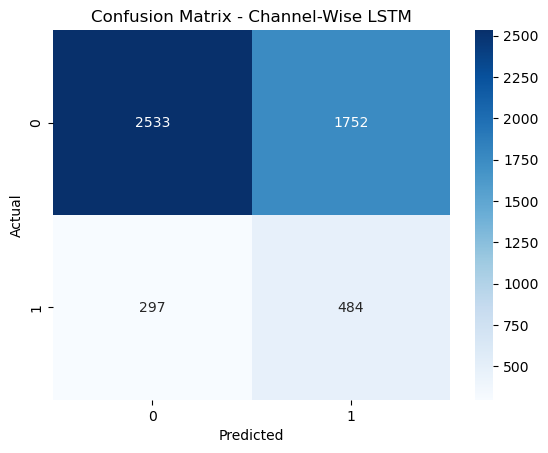

In [164]:
# Predict the probabilities of the test data
y_pred_probs = model3.predict([padded_test_data, test_data_static])

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Channel-Wise LSTM')
plt.show()

159/159 [==============================] - 39s 243ms/step
AUC-ROC Score: 0.6136875352037973
Accuracy: 0.6466640347414133
Precision: 0.21384004537719795
Recall: 0.4827144686299616
F1 Score: 0.29638364779874216


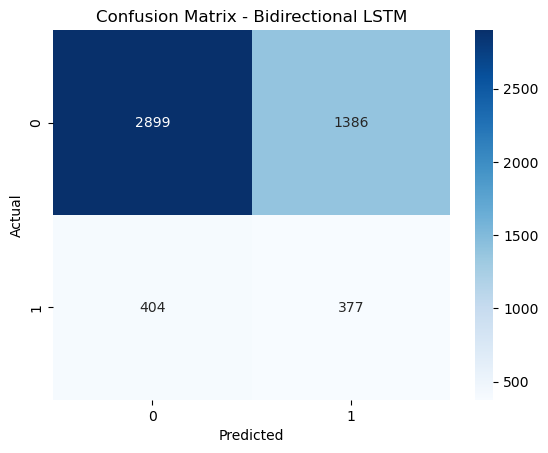

In [165]:
# Predict the probabilities of the test data
y_pred_probs = model1.predict([padded_test_data, test_data_static])

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Bidirectional LSTM')
plt.show()

In [176]:
m

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_82 (LSTM)              (None, 142, 64)           21248     
                                                                 
 dropout_14 (Dropout)        (None, 142, 64)           0         
                                                                 
 lstm_83 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_15 (Dropout)        (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 33,697
Trainable params: 33,697
Non-trainable params: 0
_________________________________________________________________


In [175]:
np.save('test_labels.npy', test_labels)
np.save('train_labels.npy', train_labels)


array([[-9.43010215e-01,  9.41605288e-17,  2.00000000e+00, ...,
         1.00000000e+00,  3.00000000e+00,  1.00000000e+00],
       [-4.24166495e-01,  9.41605288e-17,  2.00000000e+00, ...,
         1.00000000e+00,  3.00000000e+00,  1.00000000e+00],
       [-2.53206449e-01,  9.41605288e-17,  2.00000000e+00, ...,
         1.00000000e+00,  5.00000000e+00,  3.00000000e+00],
       ...,
       [-4.46780838e-01, -3.20287834e-01,  1.00000000e+00, ...,
         2.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.98470350e-01, -7.51777113e-02,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 7.75343574e-02,  9.41605288e-17,  2.00000000e+00, ...,
         1.00000000e+00,  2.00000000e+00,  1.00000000e+00]])

159/159 [==============================] - 22s 126ms/step
AUC-ROC Score: 0.4960885499695959
Accuracy: 0.44650611922621397
Precision: 0.15977127480659267
Recall: 0.6081946222791293
F1 Score: 0.2530633990410229


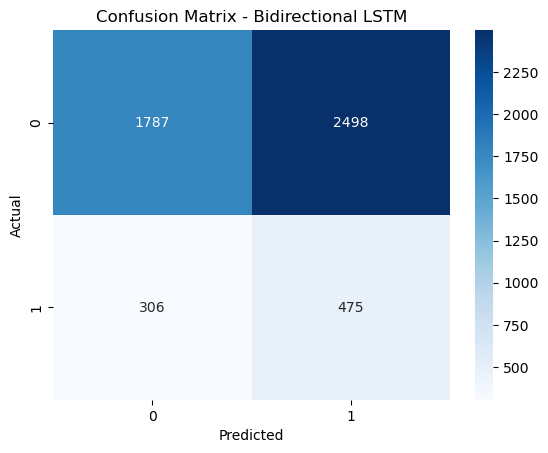

In [191]:
# Predict the probabilities of the test data
y_pred_probs = model.predict([padded_test_data, test_data_static])

# Convert the probabilities to binary predictions
y_pred = np.round(y_pred_probs)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(test_labels, y_pred_probs)

# Calculate other metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

cm = confusion_matrix(test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Bidirectional LSTM')
plt.show()

In [137]:
print('The shape of timeseries training data is: {}'.format(padded_train_data.shape))
print('The shape of timeseries testing data is: {}'.format(padded_test_data.shape))
print('The shape of static training data is: {}'.format(train_data_static.shape))
print('The shape of static test data is: {}'.format(train_data_static.shape))

The shape of timeseries training data is: (28692, 142, 18)
The shape of timeseries testing data is: (5066, 142, 18)
The shape of static training data is: (28692, 7)
The shape of static test data is: (28692, 7)


In [252]:
# Initialize counters for missing values
missing_height = 0
missing_capillary_refill_rate = 0
missing_glass = 0
for i in range(train_reader.get_number_of_examples()):
    example = train_reader.read_example(i)
    data = example['X']
    header = example['header']

    # Find the indices of the "Height" and "Capillary refill rate" features
    height_index = header.index("Height")
    capillary_refill_rate_index = header.index("Capillary refill rate")
    glass_index = header.index("Glascow coma scale total")
    

    # Count the missing values in the "Height" and "Capillary refill rate" features
    missing_height += np.sum(data[:, height_index] == '')
    missing_capillary_refill_rate += np.sum(data[:, capillary_refill_rate_index] == '')
    missing_glass += np.sum(data[:, glass_index] == '')

# Print the results
print(f"Missing values in 'Height': {missing_height}")
print(f"Missing values in 'Capillary refill rate': {missing_capillary_refill_rate}")

Missing values in 'Height': 1191916
Missing values in 'Capillary refill rate': 1192160


In [253]:
print(f"Missing values in 'Height': {missing_glass}")

Missing values in 'Height': 1065338


In [194]:
static_data_vector


[88.32839589675291, 175.0, 89.811216, 2, 2, 'metavision', 'CCU', 'EMERGENCY']

In [59]:
for i in range(len(static_data_vector)):
        if isinstance(static_data_vector[i], (int, float)):
            static_data_vector[i] = float(static_data_vector[i])

In [60]:
static_data_vector

[88.32839589675291, 175.0, 89.811216, 2, 2, 'metavision', 'CCU', 'EMERGENCY']

In [216]:
padded_val_data[0][0]

array([ 0.0000000e+00,  0.0000000e+00,  3.5330117e-01,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00, -4.8283195e+00,  0.0000000e+00,
       -6.4566798e+00, -1.5143752e+00,  0.0000000e+00,  1.1677448e-01,
        1.4550959e+00, -7.0335734e-01, -2.4767199e-01, -3.7401328e+00,
        0.0000000e+00,  1.7408250e+25], dtype=float32)

In [240]:
val_data_static

array([[-0.50818874,         nan,         nan,  1.        ,  4.        ,
         1.        ,  4.        ,  1.        ],
       [ 0.37467101,         nan,         nan,  2.        ,  1.        ,
         1.        ,  2.        ,  1.        ],
       [ 0.53498823,         nan, -0.12261712,  1.        ,  0.        ,
         1.        ,  5.        ,  1.        ],
       [ 0.39519549, -3.53553391, -0.64051463,  1.        ,  4.        ,
         2.        ,  5.        ,  2.        ],
       [ 1.04440322,         nan,         nan,  1.        ,  0.        ,
         1.        ,  2.        ,  1.        ],
       [ 1.78885607,  7.07106781,  0.59749319,  2.        ,  2.        ,
         2.        ,  2.        ,  1.        ],
       [-2.10113754,         nan,         nan,  2.        ,  4.        ,
         1.        ,  5.        ,  1.        ],
       [ 1.41483091,         nan,         nan,  1.        ,  4.        ,
         1.        ,  4.        ,  1.        ],
       [-0.30349067,         nan

In [336]:
test_data_static

array([[-0.72439295,         nan, -0.95239509,  1.        ,  0.        ,
         1.        ,  1.        ,  1.        ],
       [ 4.07634932,         nan, -0.67542541,  1.        ,  4.        ,
         1.        ,  4.        ,  1.        ],
       [ 0.02334562,         nan, -0.42538337,  2.        ,  4.        ,
         1.        ,  2.        ,  3.        ],
       [-0.0954377 ,         nan,  0.30935551,  2.        ,  4.        ,
         1.        ,  5.        ,  1.        ],
       [ 4.07637265,         nan,  0.02084546,  2.        ,  2.        ,
         1.        ,  1.        ,  1.        ],
       [ 4.07712765,         nan,  0.22857276,  2.        ,  2.        ,
         1.        ,  1.        ,  1.        ],
       [ 0.14490899,         nan, -0.09840531,  1.        ,  0.        ,
         1.        ,  5.        ,  1.        ],
       [-0.10633371,         nan, -0.51001316,  2.        ,  4.        ,
         1.        ,  1.        ,  1.        ],
       [-0.99733709,         nan

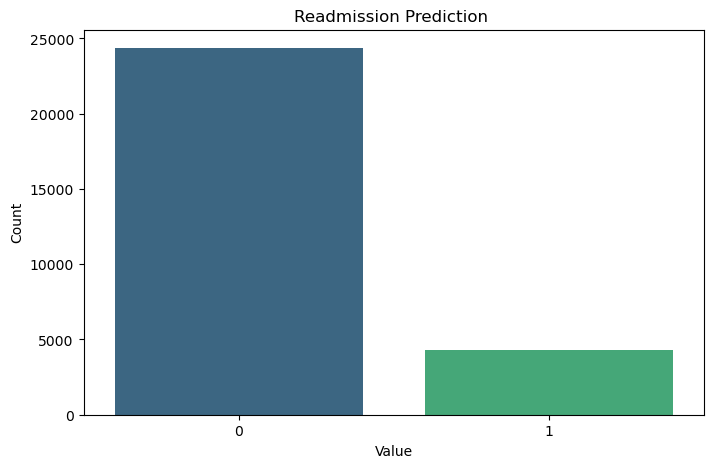

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Count the occurrences of each value
(unique_values, counts) = np.unique(train_labels, return_counts=True)

# Create a dictionary from unique values and counts
value_counts = dict(zip(unique_values, counts))

# Create a bar plot of the counts
plt.figure(figsize=(8, 5))
sns.barplot(x=list(value_counts.keys()), y=list(value_counts.values()), palette='viridis')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Readmission Prediction ')
plt.show()
